In this lab we'll look at images as data. In particular, we'll show how to use standard Python libraries to visualize and distort images, switch between matrix and vector representations, and run machine learning to perform a classification task. We'll be using the ever popular MNIST digit recognition data set. This will be a two part lab, comprised of the following steps:

Part1:
1. Generate random matrices and visualize as images
2. Data Prep and Exploration
-- Load MNIST data
-- Convert the vectors to a matrix and visualize
-- Look at pixel distributions
-- Heuristic feature reduction
-- Split data into train and validation

Part 2:
3. Classification
-- One vs. All using logisitic regression.
-- Random Forests on all
4. Error analysis
-- Visualize confusion matrix
-- Look at specific errors
5. Generate synthetic data and rerun RF



In [1]:
import os, sys
import pandas as pd
import numpy as np
#from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline


#Student: change the data directory to where you have the data
data_dir = '../data/'
data_train = data_dir + 'mnist_train_10k.csv'


# Generate Random Matrices and View as Images

Before looking at actual data, let's introduce the basic image data construct in Python. A color image is generally a 3-dimensional array with dimensions: NxMx3. The last dimension is the color channel, and the first two represent the X and Y grid of the image. The values are typically integer-valued pixel intensities for each color channel, with values between 0 and 255.

The first thing we'll do is generate a random image and look at it.

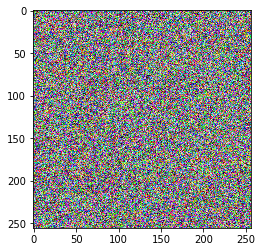

In [2]:
#Student: generate a 3-dimensional random array of integers in the range of [0,255]
x = 256
y = 256
d = 3

rand_img = np.random.randint(0, 256, size=(x, y, d), dtype='int')
img = plt.imshow(rand_img, interpolation='nearest')


Now do it again with a much smaller grid to see how it looks

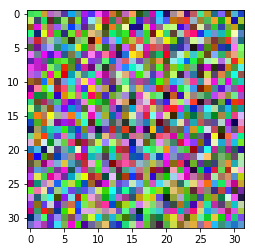

In [3]:
#another way
x = 32
y = 32
d = 3

rand_img = np.random.randint(0, 256, size=(x, y, d), dtype='int')
img = plt.imshow(rand_img, interpolation='nearest')

# Data Prep and Exploration

In [4]:
#Read in the data and take a look at the first few rows
train = pd.read_csv(data_train)
train.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Check to see the size of the data (rows and columns). Remember the first column is the label
train.shape

(10000, 785)

Now let's do a little prep on the data. We need to split the training data to produce a validation set

In [6]:
from sklearn.model_selection import train_test_split

val_pct = 0.1
X = train.drop('label', 1)
y = train.label
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_pct)

Note that this data is in a single vector format (i.e., the dimensionality of each record is 1xK, and not in the typical 2-dim photo layout). Before doing any data mining, let's first explore the data visually.

The first thing we can do is look at the actual images. What better way to visualize image data?

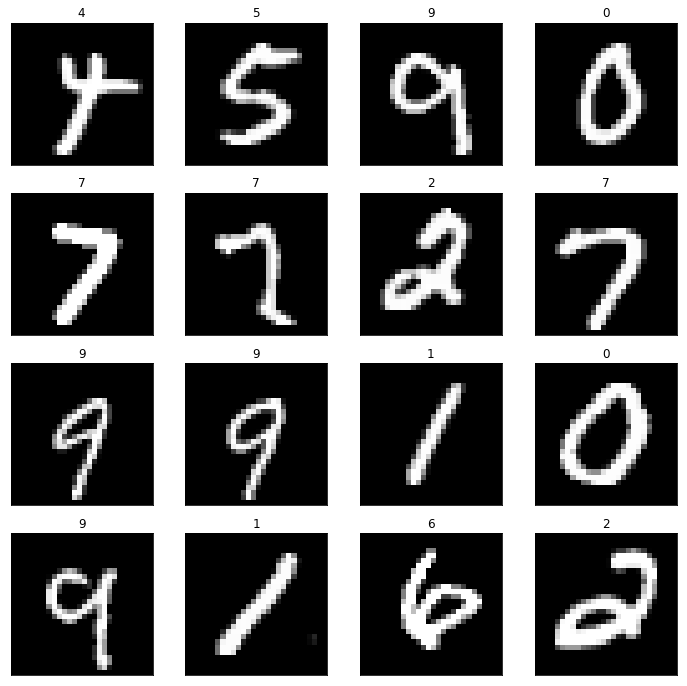

In [7]:
#First let's build a function that converts a vector into an image matrix and plots it

def plot_vector(vec):
    '''
    Takes in image vector, transforms and plots
    '''
    v_sq = np.reshape(vec, (28,28))
    plt.imshow(v_sq, interpolation='nearest', cmap = 'gray')

#plot the first few number images along with their label.
s = 16
fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plot_vector(X_train.iloc[i].values)
    plt.title(str(y_train.iloc[i]))
    plt.xticks([])
    plt.yticks([])

As we can see from the black and white images, many pixels might only have black (x=0) values. These won't be useful for modeling, so we can drop them. Write a function that finds all of the features with stdev=0 and then drop them from the training data.

In [8]:
#The describe method returns a dataframe with features as columns and distributional stats as rows
#hint: use the dataframe.describe() and drop() methods and this can be done in 2 lines
def get_no_variance_features(df):
    '''
    Input: a data frame
    Ouput: a list of features with no variance
    '''
    desc_df = df.describe()
    return desc_df.loc['std'][(desc_df.loc['std']==0)].index.values

drop_list = get_no_variance_features(X_train)

X_train_filt = X_train.drop(drop_list, 1)
X_val_filt = X_val.drop(drop_list, 1)

X_train.shape, X_train_filt.shape

((9000, 784), (9000, 669))

Let's now take a look at the distribution of pixel values in a more traditional way. Let's also look at the distribution by class to see if we see any differences. As there are many pixels, let's look at the top 4 by pixel variance.

In [9]:
#Get the standard deviation of each feature (using describe() as in above)
#Sort the results and pull out the top 4 feature names
df_std = X_train.describe().loc['std']
df_std.sort_values(ascending=False, inplace=True)
top4_list = df_std.index.values[0:4]

top4_list

array(['pixel378', 'pixel461', 'pixel406', 'pixel627'], dtype=object)

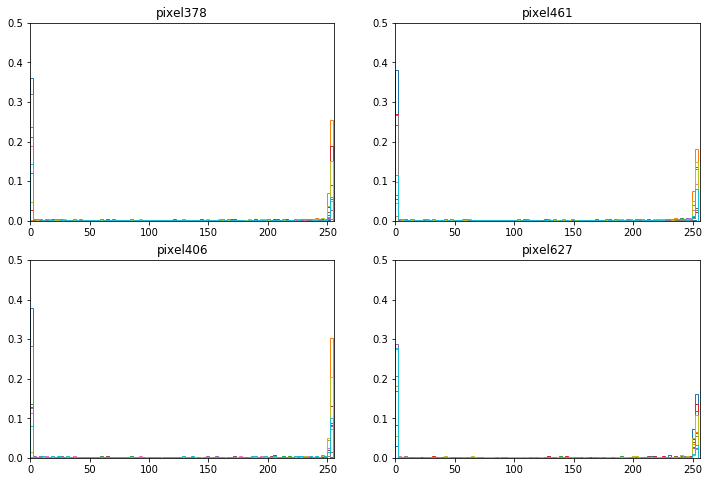

In [10]:
#Now for each feature plot the histogram by each class label
Y_labels = range(10)

fig = plt.figure(figsize=(12,8))
for i, var in enumerate(top4_list):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlim([0,256])
    ax.set_ylim([0,0.5])
    for y in Y_labels:
        plt.hist(X_train[var][(y_train==y)], bins=100, density=True, histtype='step')
        plt.title(var)

Given how polarized the pixels are, this is a bit hard to read. Next let's just look at means by label group.

In [11]:
X_samp = pd.DataFrame(X_train[top4_list])
X_samp['y'] = y_train
X_samp.groupby('y').mean()

,pixel378,pixel461,pixel406,pixel627
y,,,,
0,10.129032,3.420467,4.327030,203.450501
1,241.814590,218.545086,246.110436,101.534954
2,78.731137,176.790648,118.485654,100.976621
3,199.778643,44.236930,153.246941,176.476085
4,54.989619,168.196078,116.610150,46.280277
5,126.053892,59.868263,122.428743,156.901796
6,80.120090,138.023569,125.287318,42.535354
7,20.733549,48.208198,34.469256,87.716289
8,177.728774,186.344340,212.505896,167.311321


Can we start to see how the distributions differ by class?

# Classification

With our data generally explored and prepped and a little intuition about how pixel values might help us discrimate between the digits, let's start to use our predictive modeling tools.

We'll first start with a simple linear model. Also, this is a multi-class scenario so we can't just use and out-of-the-box logistic regression. Luckliy, like for most things machine learning, SkLearn has a tool for that.

http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

In [12]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#Next let's build the model
ova1 = OneVsRestClassifier(LogisticRegression())
ova1.fit(X_train_filt, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

Let's take a quick look under the hood of the OneVsRestClassifier object

In [13]:
ova1.__dict__.keys(), len(ova1.estimators_)

(dict_keys(['estimator', 'n_jobs', 'label_binarizer_', 'classes_', 'estimators_']),
 10)

In [14]:
ova1.estimators_[0:3]

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]

Now let's evaluate on test data using a confusion matrix

In [15]:
#First execute this function
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc = np.diag(cm).sum() / float(cm.sum())
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('{},Acc={}'.format(title, acc))
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

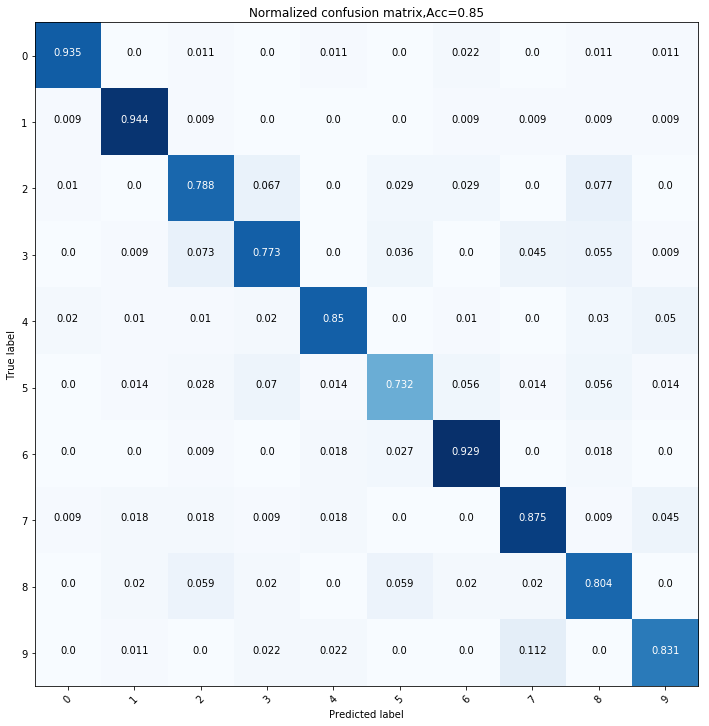

In [16]:
from sklearn.metrics import confusion_matrix

#Next, predict the class on validation data and generate the confusion_matrix
preds_ova = ova1.predict(X_val_filt)
cm = confusion_matrix(y_val, preds_ova, labels=range(10))

#Now use the function above to plot it
np.set_printoptions(precision=3)
plt.figure(figsize = (10,10))
plot_confusion_matrix(cm, classes=range(10), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Looking at the above, are any of the errors a bit weird?

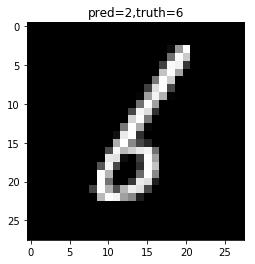

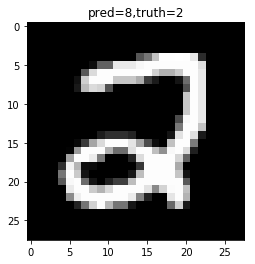

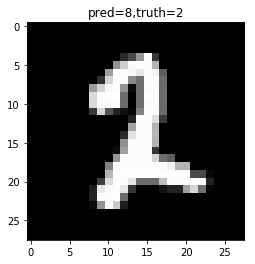

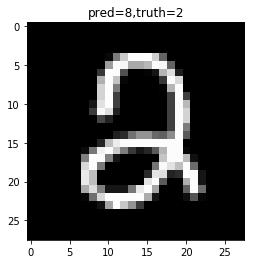

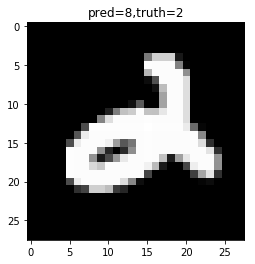

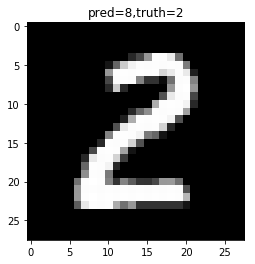

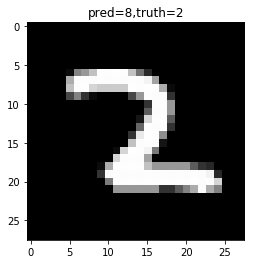

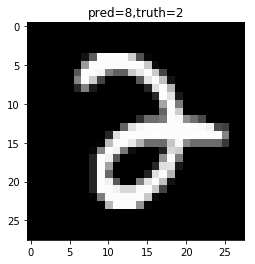

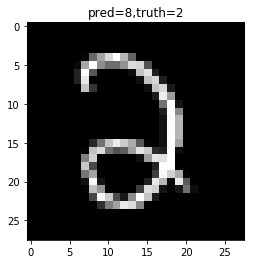

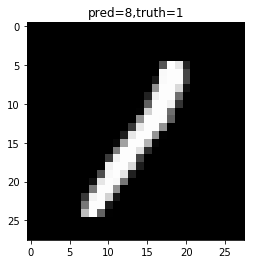

In [17]:
#Visualize errors where (pred, true) in [(2,6), (8,2),(8,1)]

pred_true_list = [(2,6), (8,2),(8,1)]
'''
Loop through the above list of tuples.
Filter out the validation records where the prediction is the first element, and the truth is the second
Then call the plot_vector function to visualize
Add a title showing prediction and truth
'''
for pt in pred_true_list:
    Xs = X_val[(y_val==pt[1]) & (preds_ova==pt[0])]
    for i in range(Xs.shape[0]):
        plt.figure()
        plot_vector(Xs.iloc[i].values)
        plt.title('pred={},truth={}'.format(pt[0],pt[1]))

This accuracy is pretty good for an untuned LR on a sample of data. Can we do better with a random forest? Without running first, why might a RF do better in this case?

# This should conclude Part 1

## RF

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(X_train_filt, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

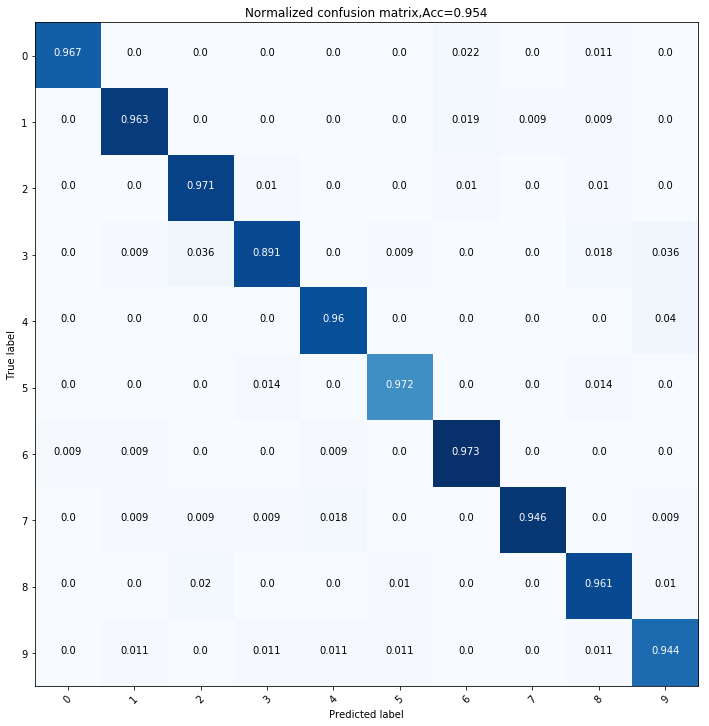

In [19]:

#Get the predictions and a confusion matrix, and plot like was done above
preds_rf = rf.predict(X_val_filt)
cm_rf = confusion_matrix(y_val, preds_rf, labels=range(10))

np.set_printoptions(precision=3)
plt.figure(figsize = (10,10))
plot_confusion_matrix(cm_rf, classes=range(10), normalize=True,
                      title='Normalized confusion matrix')

plt.show()


One interesting aspect of image is data is that we can often improve our models by using synthetic data. The key is to produce such data in a way that it doesn't deviate too far from realistic examples. We can do this by making small pertubations to the image matrix, such as adding random noise, adding blurs and by performing small rotations.

We'll do that here using tools from scipy alone (note there are other image libraries that offer even more functionality). We'll then take the augmented data set and build another random forest and see if we can improve our model.

First let's create a function that adds random gaussian noise, rotates the angle of the number, and applies some gaussian smoothing to create blur.

In [34]:
from scipy.ndimage import gaussian_filter 
#from scipy.misc import imrotate - note this has been deprecated

def distort_image(vec, noise_std, rotation_angle, blur_std):
    '''
    Pass in a row of training data and distortion params
    Return a distorted image
    Params:
    - vec: a row of MNIST data
    - noise_std: parameter to control the standard deviation of random noise
    - rotation_angle: degrees we will rotate the number
    - blur_std: parameter to control the amount of local smoothing/blurring
    
    - Note: it is best to do the rotation first
    '''
    shape = (28,28)
    mx = 255
    mn = 0
    img = np.reshape(vec, shape)
    #commenting out - imrotate has been deprecated, use skimage.transform.rotate instead
    #img_rot = imrotate(img, rotation_angle) 
    img_rot = img
    noise = np.random.normal(0, noise_std, size = shape)
    img_rot_blur = gaussian_filter(img_rot, blur_std) + noise
    #Adding noise can create values out of allowable range, so have to clip
    img_rot_blur[img_rot_blur>mx] = mx
    img_rot_blur[img_rot_blur<mn] = mn
    return img_rot_blur

Before building more training data, let's first plot some examples here.

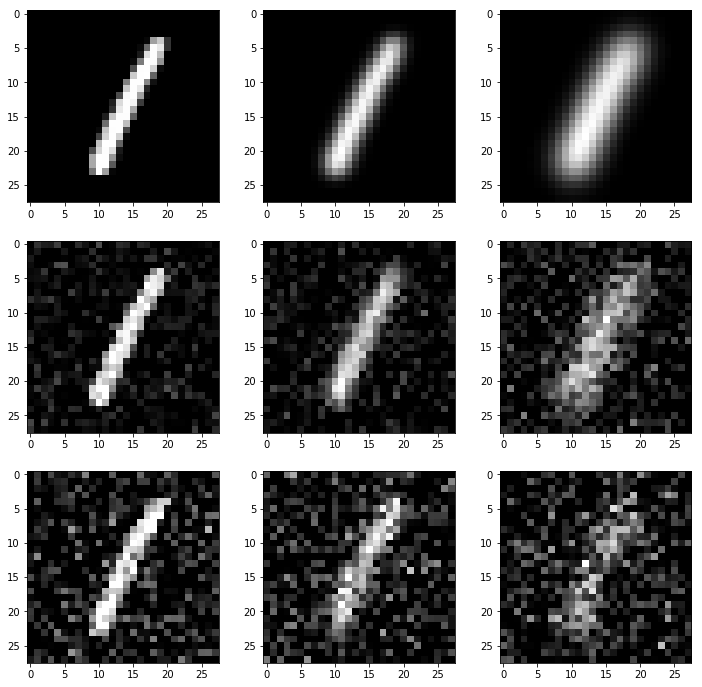

In [35]:
vec = X_train.iloc[10].values

plt.figure(figsize = (12,12))
angles = [0, -20, 20]
for i,noise in enumerate([0.1, 30, 60]):
    for j,blur in enumerate([0, 1, 2]):
        img_rot_blur = distort_image(vec, noise, angles[i], blur)
        plt.subplot(3,3,i*3+j+1)
        plt.imshow(img_rot_blur, cmap='gray')

So we need to choose distortation parameters that are significant enough to create a new image, but don't make it unreadable. This is a subjective call (which can be tested empirically...how?). What are some reasonable values?

Our next step will be to generate another 10k training data points, and then run a second random forest.

Note to students: choose your own values here, including total new and the distortation parameters. We'll execute and then see as a class what works best (in a sense we'll parallelize the exploration of the parameter space).

In [39]:
n = 10000

new_xs = []
new_ys = []
for i in range(n):
    #Get a random example, note this samples with replacement
    samp_i = np.random.randint(0,X_train.shape[0])
    vec = X_train.iloc[samp_i].values
    #Now generate some parameters, choosing them randomly
    angle = np.random.uniform(-20, 20)
    noise = 20
    blur = np.random.uniform(0,1)
    #Get a random image and convert back to 
    new_xs.append(distort_image(vec, noise, angle, blur).ravel())
    new_ys.append(y_train.iloc[samp_i])


In [40]:
#Now convert this fake data to DataFrames and append to original
X_train_fake = pd.DataFrame(new_xs, columns = X_train.columns)
y_train_fake = pd.Series(new_ys)

#Let's not forget to throw out the features we tossed out earlier
X_train_fake = X_train_fake.drop(drop_list, 1)

#Now let's concatenate the fake data to the original
X_train_aug = pd.concat([X_train_filt, X_train_fake])
y_train_aug = pd.concat([y_train, y_train_fake])

X_train_aug.shape, y_train_aug.shape

((19000, 669), (19000,))

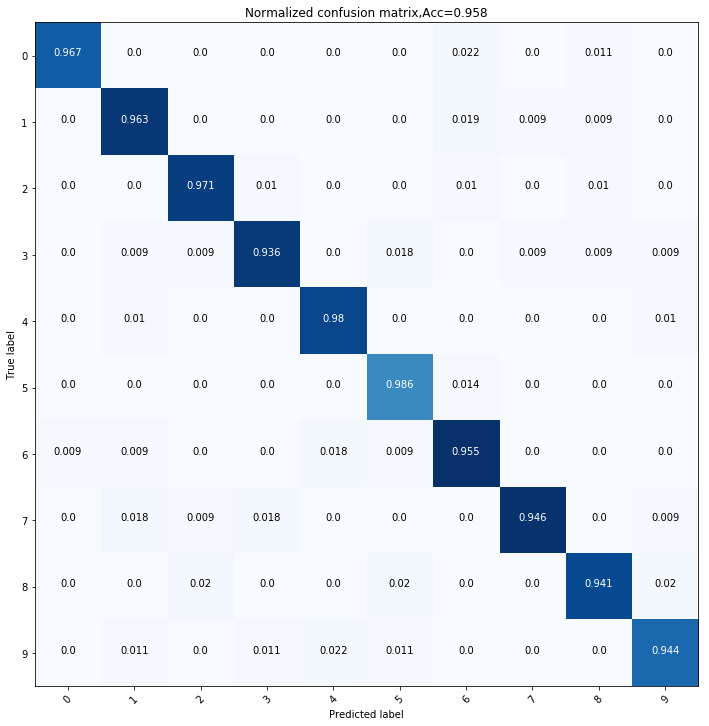

In [41]:
#Rerun RF, make predictions and plot confusion matrix as is done above
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(X_train_aug, y_train_aug)

preds_rf = rf.predict(X_val_filt)

cm_rf = confusion_matrix(y_val, preds_rf, labels=range(10))

np.set_printoptions(precision=3)
plt.figure(figsize = (10,10))
plot_confusion_matrix(cm_rf, classes=range(10), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
